In [66]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [68]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [69]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [70]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [71]:
# classes that automap found
print(base.classes.keys())

['measurement', 'station']


In [72]:
# references to each table
measurement = base.classes.measurement
station = base.classes.station

In [73]:
# session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [74]:
# the most recent date in the data set.
last_obs = session.query(func.max(measurement.date)).first()
last_obs

('2017-08-23',)

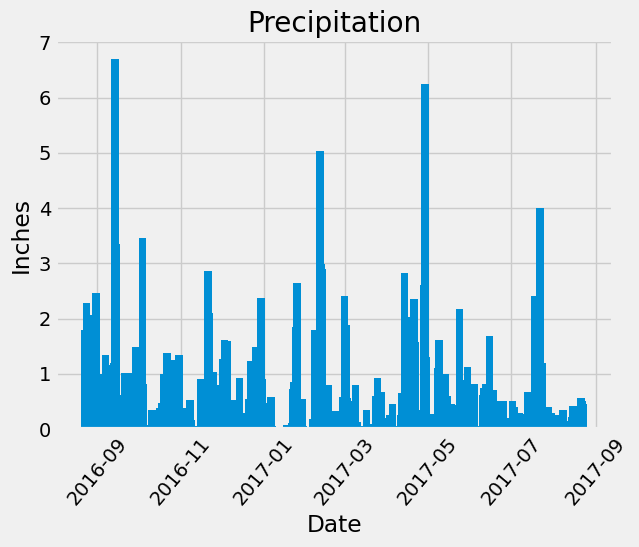

In [89]:
# get col names with sqlite viewer or use inspector ig
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_obs = dt.date(2017,8,23)
# Calculate the date one year from the last date(last_obs) in data set.
yr_pr_last_obs = last_obs - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= yr_pr_last_obs).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measure_df = pd.DataFrame(prcp_query).rename(columns = {'prcp': 'precipitation'})

# Sort the dataframe by date
measure_df['date']= pd.to_datetime(measure_df['date'], format = '%Y-%m-%d')
measure_df = measure_df.sort_values(by = ['date'])

# Matplotlib to plot the data
plt.bar(measure_df['date'], measure_df['precipitation'], align='center', width=5.5)
plt.title("Precipitation Bar Plot")
plt.xlabel("Date")
plt.xticks(rotation = 50, ha = "center")
plt.ylabel("Inches")

# finished product plt.show
plt.show()

In [76]:
# summary statistics for the precipitation data
measure_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [77]:
# query to calculate the total number of stations in the dataset
print(f'Number of Stations: ',len(session.query(station).all()))

Number of Stations:  9


In [87]:
# List the stations and their counts in descending order.
# unique_dict is no bueno, no easy way to sort dict by freq, 
# query station id's and det frequency of appearance
stations_query = session.query(measurement.station, func.count(measurement.station).label('count')) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc())
    
for station, count in stations_query:
    print(f"Station ID: {station}, Frequency: {count}")

Station ID: USC00519281, Frequency: 2772
Station ID: USC00519397, Frequency: 2724
Station ID: USC00513117, Frequency: 2709
Station ID: USC00519523, Frequency: 2669
Station ID: USC00516128, Frequency: 2612
Station ID: USC00514830, Frequency: 2202
Station ID: USC00511918, Frequency: 1979
Station ID: USC00517948, Frequency: 1372
Station ID: USC00518838, Frequency: 511


In [85]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_query[0][0]
selection = [measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_query = session.query(*selection).filter_by(station=most_active_station).all()

print(f'Most active stations lowest temp, highest temp, and average temp: ', most_active_query)

Most active stations lowest temp, highest temp, and average temp:  [('USC00519281', 54.0, 85.0, 71.66378066378067)]


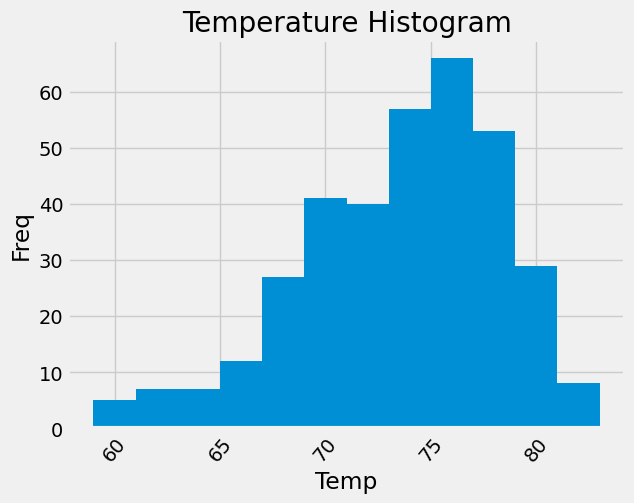

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_stn_yr = session.query(measurement.date, measurement.tobs).filter_by(station=most_active_station).filter(measurement.date >= yr_pr_last_obs).all()
most_active_stn_yr_df = pd.DataFrame(most_active_stn_yr)

plt.hist(most_active_stn_yr_df['tobs'], bins=12)
plt.title("Temperature Histogram")
plt.xlabel("Temp")
plt.xticks(rotation = 50, ha = "center")
plt.ylabel("Freq")

# finished product plt.show
plt.show()

# Close Session

In [98]:
# Close Session
session.close()